## Setup

# Tensorflow Road Signs YOLO Debugging Notebook

In [1]:
import json
from pathlib import Path

# Import third-party Python packages
import numpy as np
import imgaug as ia
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Import utils.py file
import utils

# Import training script objects
from scripts.speedlimit_only_dataset import load_xml, extract_roadsigns_annotation_data_from_xml
from train_script import input_image_shape, efficientnet_model, efficientnet_bbox_nms, efficientnet_testing_bbox_nms, efficientnet_testing_data, efficientnet_testing_data_filepaths, get_predicted_bbox_images, efficientnet_yolo_loss, Adam
from mitre.securingai.sdk.utilities.logging import configure_structlog, set_logging_level

# Create random number generator
rng = np.random.default_rng(54399264723942495723666216079516778448)

set_logging_level("INFO")
configure_structlog()


2022-03-13 19:07:29.777533: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CHECKPOINTS_DIR = Path("checkpoints")
PATCHES_DIR = Path("patches")
RESULTS_JSON_FILE = Path("roadsigns_results.json")
PATCHED_RESULTS_JSON_FILE = Path("roadsigns_patched_results.json")
PATCHED_SPINDLE10_RESULTS_JSON_FILE = Path("roadsigns_patched_spindle10_results.json")
PATCHED_SPINDLE20_RESULTS_JSON_FILE = Path("roadsigns_patched_spindle20_results.json")
PATCHED_SPINDLE30_RESULTS_JSON_FILE = Path("roadsigns_patched_spindle30_results.json")
PATCHED_DPATCH10_RESULTS_JSON_FILE = Path("roadsigns_patched_dpatch10_results.json")
PATCHED_DPATCH20_RESULTS_JSON_FILE = Path("roadsigns_patched_dpatch20_results.json")
PATCHED_ROBUST_DPATCH1785_RESULTS_JSON_FILE = Path("roadsigns_patched_robust_dpatch1785_results.json")
COCO_LABELS_FILE = Path("data") / "Road-Sign-Detection-v2" / "coco.json"

MODEL_WEIGHTS = CHECKPOINTS_DIR / "train3-weights.100-0.393.hdf5"

IMAGENET_PATCHES_DIR = PATCHES_DIR / "imagenet_patches"
PAPER_PATCHES_DIR = PATCHES_DIR / "paper_patches"
VIVID_IMAGENET_PATCHES_DIR = PATCHES_DIR / "vivid_imagenet_patches"

In [3]:
efficientnet_model.build((None, input_image_shape[0], input_image_shape[1], input_image_shape[2]))
efficientnet_model.load_weights(str(MODEL_WEIGHTS))

In [15]:
full_patched_spindle10_coco_results = []
iterations_count = 0
predictions_for_metrics_spindle10 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.1, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle10)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle10)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_spindle10_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_spindle10_coco_results2 = []

for result in full_patched_spindle10_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_spindle10_coco_results2.append(result_dict)

full_patched_spindle10_coco_results2 = sorted(full_patched_spindle10_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_SPINDLE10_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_spindle10_coco_results2, fp=f)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


In [22]:
full_patched_spindle20_coco_results = []
iterations_count = 0
predictions_for_metrics_spindle20 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.2, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle20)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle20)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_spindle20_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_spindle20_coco_results2 = []

for result in full_patched_spindle20_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_spindle20_coco_results2.append(result_dict)

full_patched_spindle20_coco_results2 = sorted(full_patched_spindle20_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_SPINDLE20_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_spindle20_coco_results2, fp=f)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


In [4]:
full_patched_dpatch10_coco_results = []
iterations_count = 0
predictions_for_metrics_dpatch10 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "dpatch.png", 0.2, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_dpatch10)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_dpatch10)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_dpatch10_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_dpatch10_coco_results2 = []

for result in full_patched_dpatch10_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_dpatch10_coco_results2.append(result_dict)

full_patched_dpatch10_coco_results2 = sorted(full_patched_dpatch10_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_DPATCH10_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_dpatch10_coco_results2, fp=f)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


In [56]:
full_patched_dpatch20_coco_results = []
iterations_count = 0
predictions_for_metrics_dpatch20 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "dpatch.png", 0.2, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_dpatch20)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_dpatch20)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_dpatch20_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_dpatch20_coco_results2 = []

for result in full_patched_dpatch20_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_dpatch20_coco_results2.append(result_dict)

full_patched_dpatch20_coco_results2 = sorted(full_patched_dpatch20_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_DPATCH20_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_dpatch20_coco_results2, fp=f)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


In [ ]:
full_patched_robust_dpatch1785_coco_results = []
iterations_count = 0
predictions_for_metrics_robust_dpatch1785 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "robust_dpatch1.png", 0.1785, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_robust_dpatch1785)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_robust_dpatch1785)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        # for result in coco_results:
        #     bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
        #     result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_patched_robust_dpatch1785_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_patched_robust_dpatch1785_coco_results2 = []

for result in full_patched_robust_dpatch1785_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_robust_dpatch1785_coco_results2.append(result_dict)

full_patched_robust_dpatch1785_coco_results2 = sorted(full_patched_robust_dpatch1785_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with PATCHED_ROBUST_DPATCH1785_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_robust_dpatch1785_coco_results2, fp=f)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


In [8]:
full_coco_results = []
full_patched_spindle30_coco_results = []
iterations_count = 0
predictions_for_metrics_spindle30 = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.3, efficientnet_testing_data_filepaths)

while True:
    try:
        pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle30)
        patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle30)
        xml_annotations_filepath = Path("data") / "Road-Sign-Detection-v2" / "annotations" / Path(efficientnet_testing_data_filepaths[iterations_count]).with_suffix(".xml").name
        xml_annotation_data = extract_roadsigns_annotation_data_from_xml(load_xml(xml_annotations_filepath)[1])
        img_width = int(xml_annotation_data["image_width"])
        img_height = int(xml_annotation_data["image_height"])

        for result in coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        for result in patched_coco_results:
            bbox = [result["bbox"][0] * img_width, result["bbox"][1] * img_height, result["bbox"][2] * img_width, result["bbox"][3] * img_height]
            result["bbox"] = bbox

        full_coco_results.extend(coco_results)
        full_patched_spindle30_coco_results.extend(patched_coco_results)

        if iterations_count % 10 == 0:
            print(iterations_count)

        iterations_count += 1

    except (StopIteration, IndexError):
        break

full_coco_results2 = []
full_patched_spindle30_coco_results2 = []

for result in full_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_coco_results2.append(result_dict)

for result in full_patched_spindle30_coco_results:
    if not result["score"] < 1e-6:
        result_dict = {}
        for k, v in result.items():
            if k == "category_id":
                result_dict[k] = int(v)

            elif k == "image_id":
                result_dict[k] = int(v)

            elif k == "bbox":
                result_dict[k] = [round(float(x), 1) for x in v]

            elif k == "score":
                result_dict[k] = round(float(v), 6)

            else:
                result_dict[k] = v

        full_patched_spindle30_coco_results2.append(result_dict)

full_coco_results2 = sorted(full_coco_results2, key=lambda x: (x["image_id"], x["score"]))
full_patched_spindle30_coco_results2 = sorted(full_patched_spindle30_coco_results2, key=lambda x: (x["image_id"], x["score"]))

with RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_coco_results2, fp=f)

with PATCHED_SPINDLE30_RESULTS_JSON_FILE.open("wt") as f:
    json.dump(obj=full_patched_spindle30_coco_results2, fp=f)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870


In [61]:
coco_gt = COCO(str(COCO_LABELS_FILE))
coco_dt = coco_gt.loadRes(str(RESULTS_JSON_FILE))
coco_dt_patched = coco_gt.loadRes(str(PATCHED_DPATCH10_RESULTS_JSON_FILE))
coco_annotation_type = "bbox"

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [62]:
coco_eval = COCOeval(coco_gt, coco_dt, coco_annotation_type)
coco_eval_patched = COCOeval(coco_gt, coco_dt_patched, coco_annotation_type)

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval_patched.evaluate()
coco_eval_patched.accumulate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.58s).
Accumulating evaluation results...
DONE (t=0.09s).
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.10s).


In [59]:
coco_eval.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.509


In [63]:
coco_eval_patched.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.252
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.072
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.413


In [ ]:
coco_eval_patched.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.071
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.298
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.123
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.387


In [5]:
predictions_for_metrics_spindle10_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.1, efficientnet_testing_data_filepaths)

In [6]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle10_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle10_plotting)


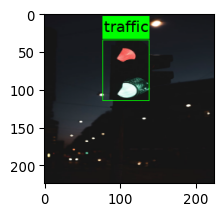

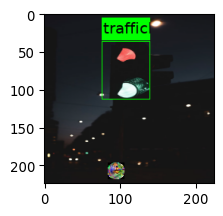

In [7]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [39]:
predictions_for_metrics_spindle20_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.2, efficientnet_testing_data_filepaths)

In [48]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle20_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle20_plotting)

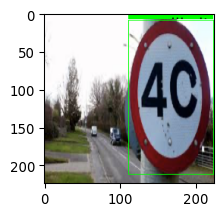

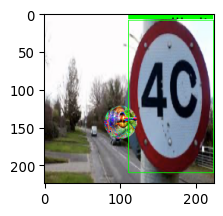

In [49]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [61]:
predictions_for_metrics_spindle30_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, VIVID_IMAGENET_PATCHES_DIR / "imagenet_patch_7_target_spindle.png", 0.3, efficientnet_testing_data_filepaths)

In [70]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_spindle30_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_spindle30_plotting)

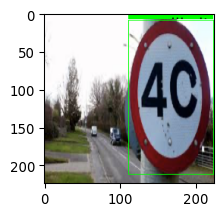

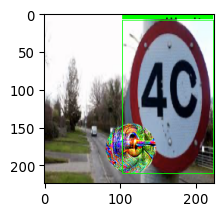

In [71]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [31]:
predictions_for_metrics_dpatch10_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "dpatch.png", 0.1, efficientnet_testing_data_filepaths)

In [54]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_dpatch10_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_dpatch10_plotting)

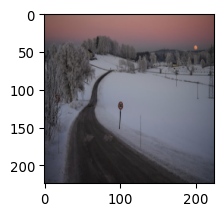

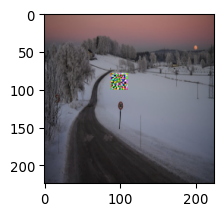

In [55]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)

In [20]:
predictions_for_metrics_robust_dpatch1785_plotting = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_testing_bbox_nms, PATCHES_DIR / "robust_dpatch2.png", 0.1785, efficientnet_testing_data_filepaths)

In [31]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba, coco_results = next(predictions_for_metrics_robust_dpatch1785_plotting)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba, patched_coco_results = next(predictions_for_metrics_robust_dpatch1785_plotting)

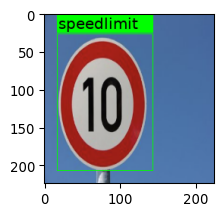

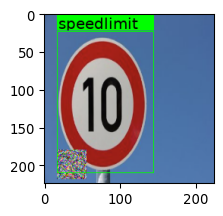

In [32]:
ia.imshow(pred_image)
ia.imshow(patched_pred_image)